# Validating Planck

In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)

sys.path.insert(1, '/home/jaimerz/PhD/xCell')

from xcell.mappers import MapperP15tSZ
from xcell.mappers import MapperP15CIB
from xcell.mappers import MapperP18SMICA

from xcell.mappers import utils
from astropy.io import fits
from astropy.table import Table
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import numpy as np

# Configs

In [6]:
nside = 2048
#ells = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240, 272, 309,
#        351, 398, 452, 513, 582, 661, 750, 852, 967, 1098,
#        1247, 1416, 1536, 1608, 1826, 2073, 2354, 2673, 3072])
Tab4 = np.array([[10, 5.0496e-03, 1.3919e-01, 5.7234e-03],
        [13.5, 8.7080e-03, 1.1643e-01, 7.5606e-03],
        [18, 1.3430e-02, 9.9155e-02, 9.9280e-03],
        [23.5, 2.9325e-02, 8.6276e-02, 1.2834e-02],
        [30.5, 2.1520e-02, 7.4827e-02, 1.6544e-02],
        [40, 2.6605e-02, 6.4972e-02, 2.1591e-02],
        [52.5, 3.9626e-02, 5.6584e-02, 2.8250e-02],
        [68.5, 3.9820e-02, 4.9513e-02, 3.6721e-02],
        [89.5, 6.0241e-02, 4.3516e-02, 4.7775e-02],
        [117, 9.9878e-02, 3.8669e-02, 6.2081e-02],
        [152.5, 1.1375e-01, 3.4993e-02, 8.0185e-02],
        [198, 1.3429e-01, 3.2630e-02, 1.0271e-01],
        [257.5, 1.7920e-01, 3.3977e-02, 1.3093e-01],
        [335.5, 2.2076e-01, 4.3272e-02, 1.6575e-01],
        [436.5, 2.6166e-01, 6.0483e-02, 2.0728e-01],
        [567.5, 2.7879e-01, 7.9377e-02, 2.5553e-01],
        [738, 3.3226e-01, 1.1034e-01, 3.0982e-01],
        [959.5, 4.3979e-01, 1.4774e-01, 3.6810e-01],
        [1247.5, 0, 0, 4.2699e-01],
        [1622, 0, 0, 4.8154e-01],
        [2109, 0, 0, 5.2553e-01],
        [2742, 0, 0, 5.5249e-01]])
ells = np.array([int(x) for x in np.transpose(Tab4)[0]])
tSZDl_ref = np.transpose(Tab4)[1]
ells = ells[ells<3*nside]
#bands = nmt.NmtBin(nside, nlb=4, is_Dell=False)
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [7]:
path_tSZ = '/home/jaimerz/PhD/xCell/data/P18/tSZ/'
tSZ_c = {'file_map': path_tSZ+'COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits', 
    'file_hm1': None, 
     'file_hm2': None,
     'file_noise': path_tSZ+'COM_CompMap_Compton-SZMap-milca-stddev_2048_R2.00.fits',
     'file_mask': path_tSZ+'COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits',
     'mask_name': 'mask_tSZ',
     'nside': nside}
path_SMICA = '/home/jaimerz/PhD/xCell/data/P18/SMICA/'
SMICA_c = {'file_map': path_SMICA+'COM_CMB_IQU-smica-nosz_2048_R3.00_full.fits',
     'file_hm1': path_SMICA+'COM_CMB_IQU-smica-nosz_2048_R3.00_hm1.fits', 
     'file_hm2': path_SMICA+'COM_CMB_IQU-smica-nosz_2048_R3.00_hm2.fits',
     'file_mask': None,
     'file_gp_mask': path_SMICA+'HFI_Mask_GalPlane-apo2_2048_R2.00.fits',
     'file_sp_mask': path_SMICA+'HFI_Mask_PointSrc_2048_R2.00.fits',
    'nside': nside}
path_CIB = '/home/jaimerz/PhD/xCell/data/P18/CIB/'
CIB_c = {'file_map': path_CIB+'COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits',
         'file_hm1': path_CIB+'COM_CMB_IQU-nilc_2048_R3.00_hm1.fits', 
         'file_hm2': path_CIB+'COM_CMB_IQU-nilc_2048_R3.00_hm2.fits',
         'file_mask': None,
         'file_gp_mask': path_SMICA+'HFI_Mask_GalPlane-apo2_2048_R2.00.fits',
         'file_sp_mask': path_SMICA+'HFI_Mask_PointSrc_2048_R2.00.fits',
    'nside': nside}
path = '/home/jaimerz/PhD/xCell/'
c_test = {'file_map': path+'xcell/tests/data/map.fits',
        'file_mask': path+'xcell/tests/data/map.fits',
        'nside': 32}

# tSZ

In [11]:
tSZ_mapper = MapperP15tSZ(tSZ_c)
tSZ_full = tSZ_mapper.get_signal_map()
tSZ_full_f = tSZ_mapper.get_nmt_field()
tSZ_hm1, tSZ_hm2 = tSZ_mapper._get_hm_maps()
tSZ_hm1_f = tSZ_mapper._get_nmt_field(signal=tSZ_hm1)
tSZ_hm2_f = tSZ_mapper._get_nmt_field(signal=tSZ_hm2)
tSZ_diff = tSZ_mapper._get_diff_map()
tSZ_diff_f = tSZ_mapper.get_nmt_field(signal=tSZ_diff)
tSZ_mask= tSZ_mapper.get_mask()

## Plots

/home/jaimerz/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

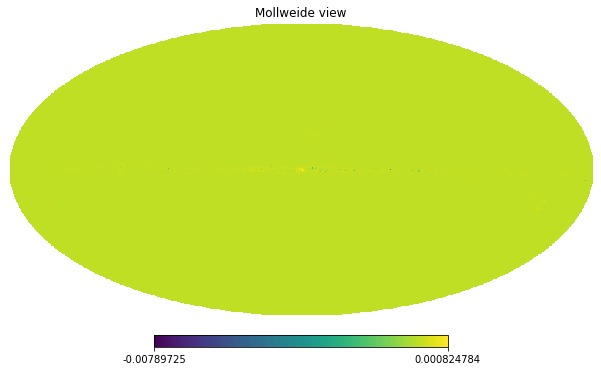

In [12]:
hp.visufunc.mollview(tSZ_full[0])

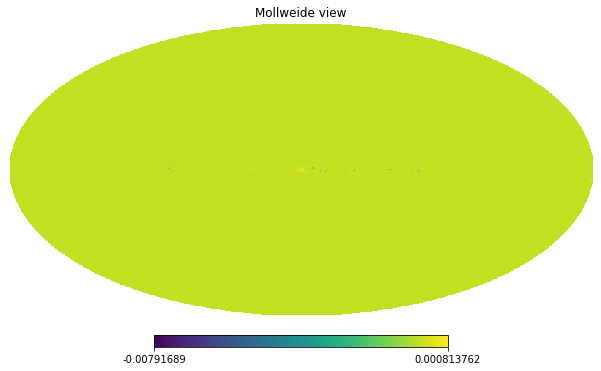

In [13]:
hp.visufunc.mollview(tSZ_hm1[0])

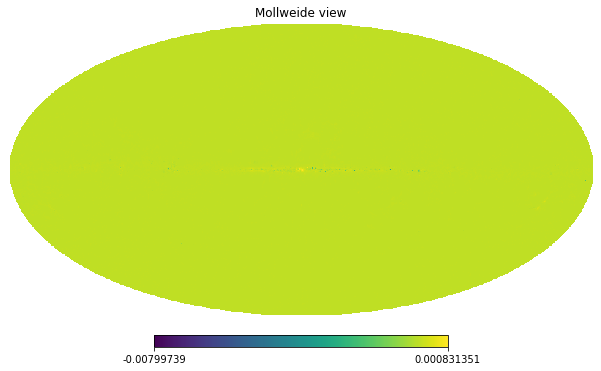

In [14]:
hp.visufunc.mollview(tSZ_hm2[0])

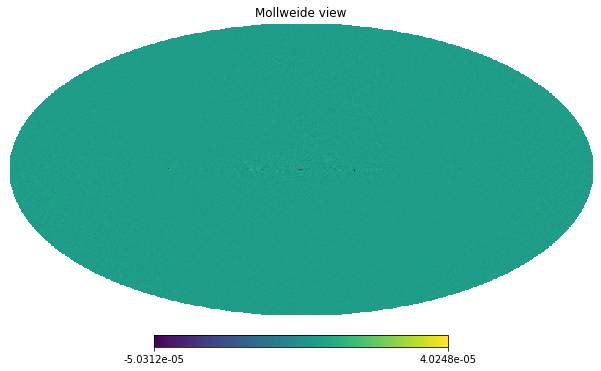

In [15]:
hp.visufunc.mollview(tSZ_diff[0])

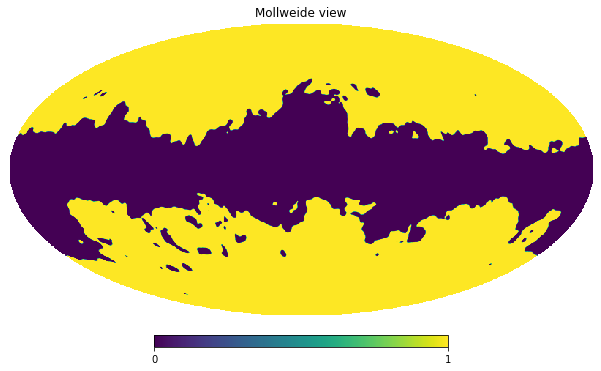

In [16]:
hp.visufunc.mollview(tSZ_mask)

## cls

In [17]:
tSZ_ws = nmt.NmtWorkspace()
tSZ_ws.compute_coupling_matrix(tSZ_full_f, tSZ_full_f, bands)

In [20]:
# Noise
tSZ_nl_c = tSZ_mapper.get_nl_coupled()
tSZ_nl_dc = tSZ_ws.decouple_cell(tSZ_nl_c)

# Already without noise
tSZ_cl_full_c = nmt.compute_coupled_cell(tSZ_full_f, tSZ_full_f)
tSZ_cl_full_dc = tSZ_ws.decouple_cell(tSZ_cl_full_c) 

# Already without noise
tSZ_cl_fl_c = nmt.compute_coupled_cell(tSZ_hm1_f, tSZ_hm2_f)
tSZ_cl_fl_dc = tSZ_ws.decouple_cell(tSZ_cl_fl_c) 

In [45]:
tSZ_dl_full_dc = tSZ_cl_full_dc*(10**12*ell_arr*(ell_arr+1))/(2*np.pi)#/(2.7255)**2
tSZ_dl_fl_dc = tSZ_cl_fl_dc*(10**12*ell_arr*(ell_arr+1))/(2*np.pi)#/(2.7255)**2
tSZ_dnl_dc = tSZ_nl_dc*(10**12*ell_arr*(ell_arr+1))/(2*np.pi)#/(2.7255)**2

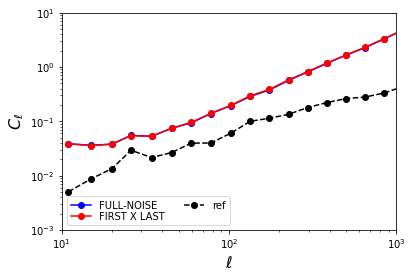

In [47]:
plt.plot(ell_arr, tSZ_dl_full_dc[0]-tSZ_dnl_dc[0], 'bo-', label='FULL-NOISE')
#plt.plot(ell_arr, tSZ_dl_full_dc[0], 'o-', label='FULL-NOISE')
plt.plot(ell_arr, tSZ_dl_fl_dc[0], 'ro-', label='FIRST X LAST')
plt.plot(ell_arr, tSZDl_ref[:-1], 'ko--', label='ref')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.loglog()
plt.ylim(0.001, 10)
plt.xlim(10, 1000)
plt.show()

# CIB 

In [ ]:
CIB_mapper = MapperP15CIB(CIB_c)
CIB_map = CIB_mapper.get_signal_map()
CIB_mask = CIB_mapper.get_mask()
CIB_f = CIB_mapper.get_nmt_field()

## Plots

In [ ]:
hp.visufunc.mollview(CIB_map[0])

In [ ]:
hp.visufunc.mollview(CIB_mask)

## Cls

In [ ]:
CIB_ws = nmt.NmtWorkspace()
CIB_ws.compute_coupling_matrix(CIB_f, CIB_f, bands)

In [ ]:
# Noise
CIB_nl_c = CIB_mapper.get_nl_coupled()
CIB_nl_dc = CIB_ws.decouple_cell(CIB_nl_c)

# With noise
CIB_cl_c = nmt.compute_coupled_cell(CIB_f, CIB_f)
CIB_cl_dc = CIB_ws.decouple_cell(CIB_cl_c) 

In [ ]:
from astropy import units as u
from astropy.cosmology import Planck15
freq = 545 * u.GHz
equiv = u.thermodynamic_temperature(freq, Planck15.Tcmb0)
(1. * u.mK).to(u.MJy / u.sr, equivalencies=equiv)  

In [ ]:
CIB_dl_dc = ell_arr*(ell_arr+1)*CIB_cl_dc/(2*np.pi)
CIB_dl_dc /= 0.057116974**2 #(2.7260*10**6)**2

In [ ]:
CIB_dnl_dc = ell_arr*(ell_arr+1)*CIB_nl_dc/(2*np.pi)
CIB_dnl_dc /= 0.057116974**2 #(2.7260*10**6)**2

In [ ]:
plt.plot(ell_arr, CIB_dl_dc[0]-CIB_dnl_dc[0], 'b-', label='CIB')
plt.loglog()
plt.title('CIB 545')
#plt.ylim(100, 6000)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$D_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(ell_arr, CIB_dnl_dc[0], 'b-', label='CIB')
plt.loglog()
plt.title('CIB 545')
#plt.ylim(100, 6000)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$D_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

# SMICA 

In [ ]:
SMICA_mapper = MapperP18SMICA(SMICA_c)
SMICA_full = SMICA_mapper.get_signal_map()
SMICA_full_f = SMICA_mapper.get_nmt_field()
SMICA_hm1, SMICA_hm2 = SMICA_mapper._get_hm_maps()
SMICA_hm1_f = SMICA_mapper._get_nmt_field(signal=SMICA_hm1)
SMICA_hm2_f = SMICA_mapper._get_nmt_field(signal=SMICA_hm2)
SMICA_diff = SMICA_mapper._get_diff_map()
SMICA_diff_f = SMICA_mapper.get_nmt_field(signal=SMICA_diff)
SMICA_mask= SMICA_mapper.get_mask()

## Plots

In [ ]:
hp.visufunc.mollview(SMICA_mask)

In [ ]:
hp.visufunc.mollview(SMICA_full[0])

In [ ]:
hp.visufunc.mollview(SMICA_hm1[0])

In [ ]:
hp.visufunc.mollview(SMICA_hm2[0])

In [ ]:
hp.visufunc.mollview(SMICA_diff[0])

## Cls

In [ ]:
SMICA_ws = nmt.NmtWorkspace()
SMICA_ws.compute_coupling_matrix(SMICA_full_f, SMICA_full_f, bands)

In [ ]:
# Noise
SMICA_nl_c = SMICA_mapper.get_nl_coupled()
SMICA_nl_dc = SMICA_ws.decouple_cell(SMICA_nl_c)

# With noise
SMICA_cl_full_c = nmt.compute_coupled_cell(SMICA_full_f, SMICA_full_f)
SMICA_dl_full_dc = SMICA_ws.decouple_cell(SMICA_cl_full_c) 

# Already without noise
SMICA_cl_fl_c = nmt.compute_coupled_cell(SMICA_hm1_f, SMICA_hm2_f)
SMICA_dl_fl_dc = SMICA_ws.decouple_cell(SMICA_cl_fl_c) 

In [ ]:
SMICA_dl_full_dc *= ell_arr*(ell_arr+1)/(2*np.pi)
#SMICA_dl_full_dc *= (2.7255*10**6)**2
SMICA_dl_full_dc *= (10**6)**2
SMICA_dl_fl_dc *= ell_arr*(ell_arr+1)/(2*np.pi)
#SMICA_dl_fl_dc *= (2.7255*10**6)**2
SMICA_dl_fl_dc *= (10**6)**2

In [ ]:
plt.plot(ell_arr, SMICA_dl_full_dc[0], 'b-', label='Full')
plt.plot(ell_arr, SMICA_dl_fl_dc[0], 'r--', label='1x2')
#plt.plot(ell_arr, cross_corr_theory , 'r--', label='Theory')
#plt.plot(ref['ell'], ref['cl'] , 'b--', label='Reference')
plt.loglog()
plt.title('SMICA')
#plt.ylim(100, 10000)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$D_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(ell_arr, SMICA_dl_full_dc[0], 'b-', label='Full')
plt.plot(ell_arr, SMICA_dl_fl_dc[0], 'r--', label='1x2')
#plt.plot(ell_arr, cross_corr_theory , 'r--', label='Theory')
#plt.plot(ref['ell'], ref['cl'] , 'b--', label='Reference')
#plt.loglog()
plt.title('SMICA')
plt.ylim(100, 6000)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$D_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()